<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 12: Decision Trees and Random Forests</h2>
<br>
 
<a href="#1.-Work-Analytics-Data">Work Analytics Data</a> <br>
<a href="#2.-Explorary-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#3.-Feature-Engineering">Feature Engineering</a> <br>
<a href="#4.-Decision-Tree">Decision Tree</a> <br>
<a href="#5.-Bagging">Bagging</a> <br>
<a href="#6.-Random-Forest">Random Forest</a> <br>
<a href="#7.-Probability-Calibration">Probability Calibration</a> <br>
<a href="#8.-Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods
from sklearn.linear_model import LogisticRegression

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss

### 1. HR Analytics Data

We use the [Human Resources Analytics](https://www.kaggle.com/ludobenistant/hr-analytics) data available from [Kaggle Datasets](https://www.kaggle.com/datasets).

**Problem formulation:**  our objective is predict which employees will leave the company with maximum accuracy.

In [4]:
data = pd.read_csv('Data\HR.csv')
data = data.rename(columns = {'sales' : 'role'})
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,role,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
response='left'
predictors = list(data.columns.values)
predictors.remove(response)

index_train, index_test  = train_test_split(np.array(data.index), stratify=data[response], train_size=0.5, random_state=5)

train = data.loc[index_train,].copy()
test =  data.loc[index_test,:].copy()

y_train = train[response]
y_test = test[response]

In [6]:
len(train)

7499

### 2. Exploratory Data Analysis

In [7]:
train.describe().round(2)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,7499.00,7499.00,7499.00,7499.00,7499.00,7499.00,7499.00,7499.00
mean,0.62,0.72,3.79,201.04,3.52,0.14,0.24,0.02
std,0.25,0.17,1.22,49.77,1.47,0.35,0.43,0.15
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00
25%,0.44,0.56,3.00,156.00,3.00,0.00,0.00,0.00
50%,0.65,0.72,4.00,200.00,3.00,0.00,0.00,0.00
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00
max,1.00,1.00,7.00,310.00,10.00,1.00,1.00,1.00


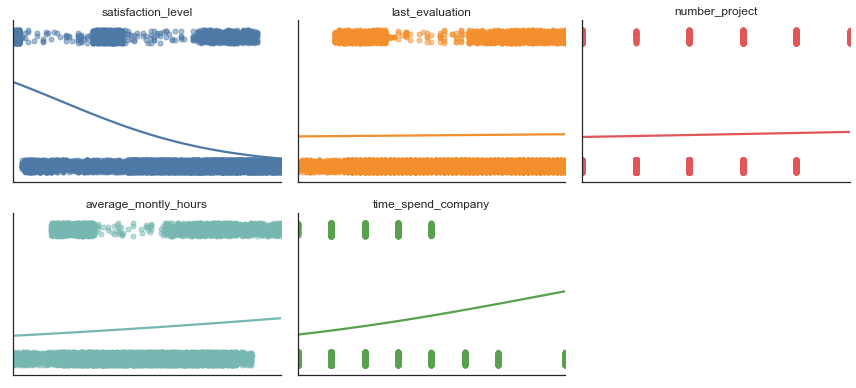

In [8]:
from statlearning import plot_logistic_regressions
plot_logistic_regressions(train[predictors].iloc[:,:5], y_train)
plt.show()

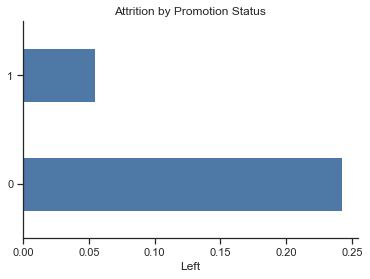

In [9]:
table = (train.groupby('promotion_last_5years')['left'].mean()).sort_values(ascending=False).round(3)
fig, ax = plt.subplots(figsize=(6, 4))
table.plot(kind='barh', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Promotion Status')
sns.despine()
plt.show()

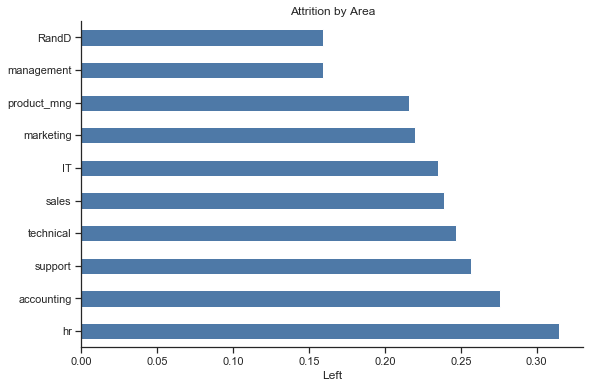

In [10]:
table = (train.groupby('role')['left'].mean()).sort_values(ascending=False).round(3)
fig, ax = plt.subplots()
table.plot(kind='barh', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Area')
sns.despine()
plt.show()

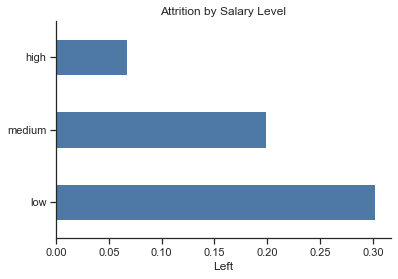

In [11]:
table = (train.groupby('salary')['left'].mean()).sort_values(ascending=False).round(3)
fig, ax = plt.subplots(figsize=(6, 4))
table.plot(kind='barh', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Salary Level')
sns.despine()
plt.show()

### 3. Feature Engineering

As mentioned in the lectures, we generally want to process the data in a specialised way for tree-based methods. We use one-hot encoding of the nominal variables for the tree-based algorithms, and dummy encoding for the logistic regression model (which will be the benchmark for the analysis). 

In [12]:
def feat_engineering(df, index_train, index_test):
    
    data = df.copy()
    dummies = pd.get_dummies(data['role'])
    data = data.join(dummies)
    data = data.drop('role', axis= 1)

    dummies = pd.get_dummies(data['salary'],  prefix = 'salary')
    data = data.join(dummies)
    data = data.drop('salary', axis= 1)
    
    predictors = list(data.columns.values)
    predictors.remove(response)
    
    X_train = data.loc[index_train, predictors].copy()
    X_test =  data.loc[index_test, predictors].copy()
    
    return X_train, X_test, predictors


def feat_engineering_logit(df, index_train, index_test):
    
    data = df.copy()
    dummies = pd.get_dummies(data['role'], drop_first=True)
    data = data.join(dummies)
    data = data.drop('role', axis= 1)

    dummies = pd.get_dummies(data['salary'],  prefix = 'salary', drop_first=True)
    data = data.join(dummies)
    data = data.drop('salary', axis= 1)
    
    predictors = list(data.columns.values)
    predictors.remove(response)
    
    X_train = data.loc[index_train, predictors].copy()
    X_test =  data.loc[index_test, predictors].copy()
    
    return X_train, X_test


X_train, X_test, predictors = feat_engineering(data, index_train, index_test)
X_train_logit, X_test_logit = feat_engineering_logit(data, index_train, index_test)

### 3. Decision Tree

The basic syntax for fitting a classification tree is as follows. We start with a small tree for visualisation.

In [13]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth = 2)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

The next cell plots the fitted tree. A limitation of this visualisation is that the predicted classes are based on the zero-one loss.

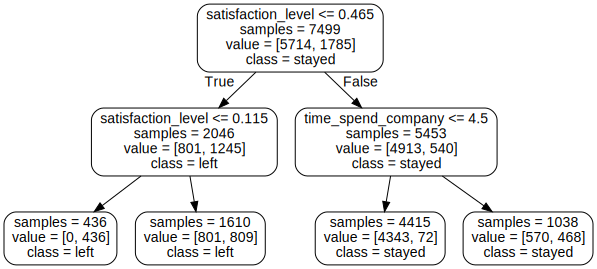

In [14]:
# You'd need to find the Graphviz path for your computer
import os
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None , impurity=False, feature_names = predictors,
                           class_names=['stayed','left'], rounded=True) 
graph = graphviz.Source(dot_data)
graph.render('tree01') # saves tree to a file
graph

Next, we optimise the hyperparameters of the decision-tree. Note that cost-complexity pruning is not available in scikit-learn, so that the process is a bit different from the lectures.

In [15]:
%%time

model = DecisionTreeClassifier(criterion='entropy')

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20,30,40,50,60,70,80,90,100,150,200,300,400,500],
}

tree_search = GridSearchCV(model, tuning_parameters, cv = 5 , scoring='neg_log_loss')
tree_search.fit(X_train, y_train)

tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'min_samples_leaf': 200} 

Wall time: 3.52 s


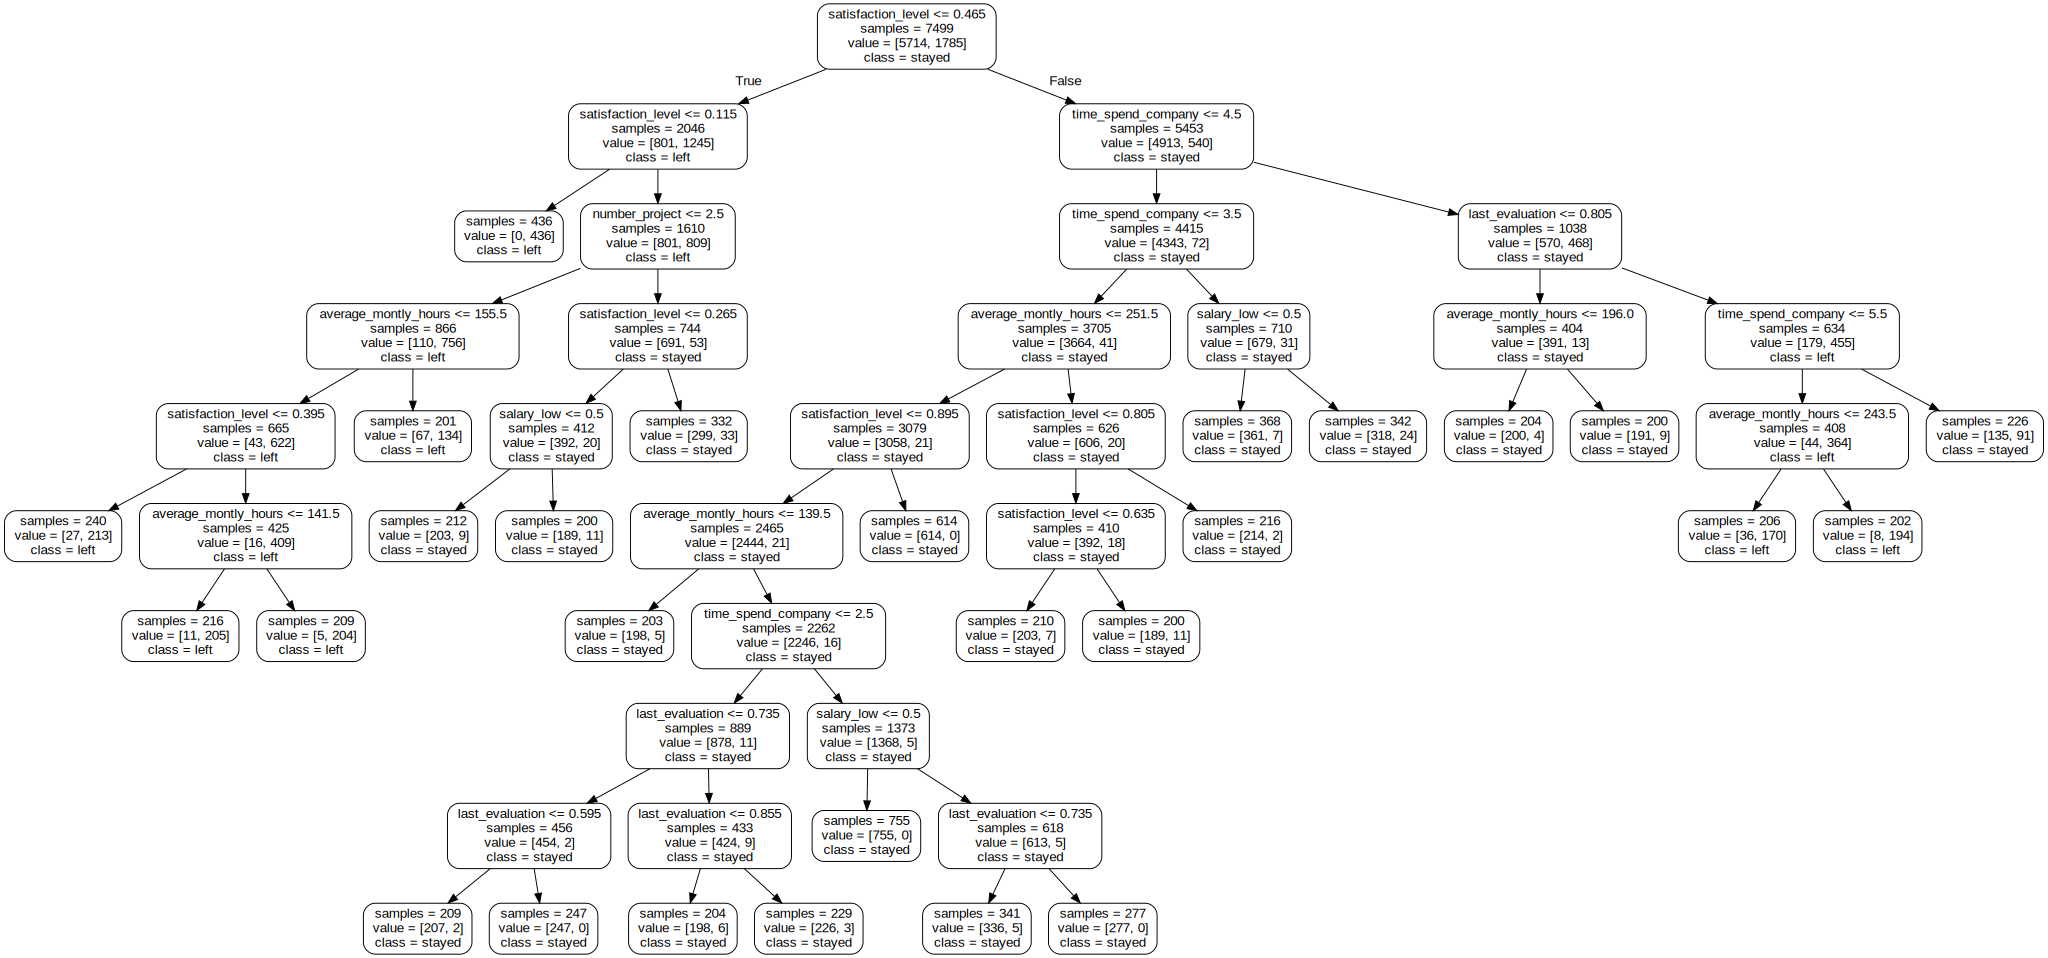

In [16]:
dot_data = export_graphviz(tree, out_file=None , impurity=False, feature_names = predictors,
                           class_names=['stayed','left'], rounded=True) 
graph = graphviz.Source(dot_data)
graph.render('tree02') # saves tree to a file
graph

### 4. Bagging

In [17]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(DecisionTreeClassifier(criterion='entropy'), n_estimators=1000, random_state=1)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=1000, n_jobs=None, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

### 5. Random Forest

The syntax to fit a [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is as follows.

In [18]:
from sklearn.ensemble import  RandomForestClassifier
rf = RandomForestClassifier(criterion='entropy', max_features= 2, min_samples_leaf=5, 
                            n_estimators=1000, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

To tune the random forest, we should select a parameter that controls the size of the trees (such as the minimum number of observations in the leaves) and the number of predictors that are sampled as candidate split variables at each node of a tree.  

In [19]:
%%time

model = RandomForestClassifier(criterion='entropy', n_estimators = 1000)

tuning_parameters = {
    'min_samples_leaf': [1],
    'max_features': np.arange(1, X_train.shape[1]),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, n_iter= 64, cv = 5, n_jobs = -1, scoring = 'neg_log_loss', 
                               random_state=1)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 1, 'max_features': 5} 

Wall time: 3min 8s


After tuning the random forest, we may want to increase the number of trees to improve accuracy. 

In [20]:
rf.n_estimators = 10000
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

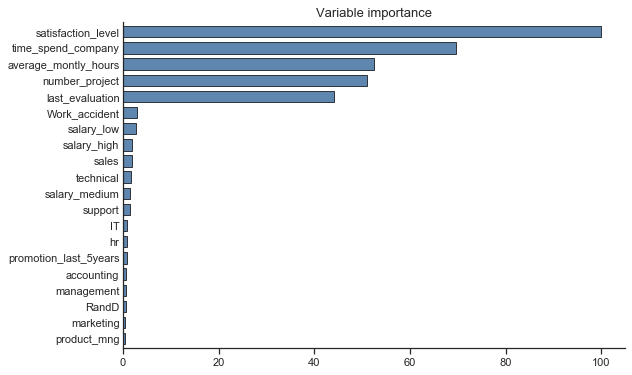

In [21]:
from statlearning import plot_feature_importance
plot_feature_importance(rf, predictors)
plt.show()

### 6. Probability Calibration

We plot the calibration curve for the random forest below. The estimated probabilities seem to be well-calibrated near the threshold, so that we don't consider additional calibration.  

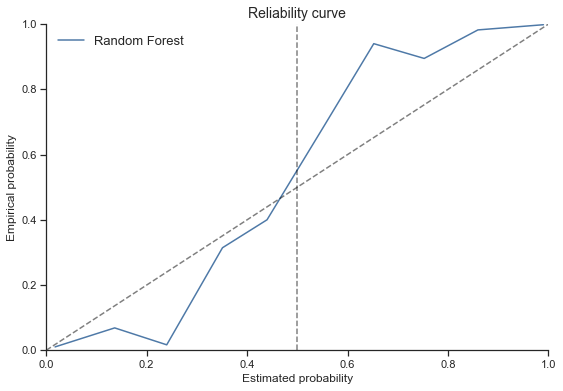

In [22]:
from statlearning import plot_calibration_curves

y_prob = cross_val_predict(rf, X_train, y_train, cv = 5, method='predict_proba')[:,1]
fig, ax = plot_calibration_curves(y_train, y_prob, labels='Random Forest')
ax.axvline(0.5, color='black', linestyle='dashed', alpha = 0.5) # decision threshold
plt.show()

In [23]:
from sklearn.calibration import CalibratedClassifierCV
rf_cal = CalibratedClassifierCV(rf, cv = 5, method='isotonic') 
rf_cal.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv=5, method='isotonic')

### 7. Model Evaluation

Our benchmark will be the logistic regression model:

In [24]:
logit = LogisticRegression(C=np.inf, solver='lbfgs')
logit.fit(X_train_logit, y_train)

LogisticRegression(C=inf, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Logistic', 'Decision Tree', 'Bagged trees', 'Random forest', 'RF (calibrated)']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, tree, bag, rf, rf_cal]

y_prob = np.zeros((len(y_test), len(rows)))

for i, method in enumerate(methods):
    
    if i==0:
        y_prob[:, i] = method.predict_proba(X_test_logit)[:, 1]
    else:
        y_prob[:, i] = method.predict_proba(X_test)[:, 1]
        
    y_pred = (y_prob[:, i] > 0.5).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_test, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_test, y_prob[:,i])
    results.iloc[i,5] =  log_loss(y_test, y_prob[:,i])
   

results.round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic,0.197,0.403,0.928,0.635,0.822,0.426
Decision Tree,0.051,0.868,0.974,0.913,0.973,0.172
Bagged trees,0.012,0.962,0.996,0.988,0.989,0.127
Random forest,0.012,0.961,0.997,0.990,0.992,0.065
RF (calibrated),0.012,0.962,0.996,0.987,0.992,0.057


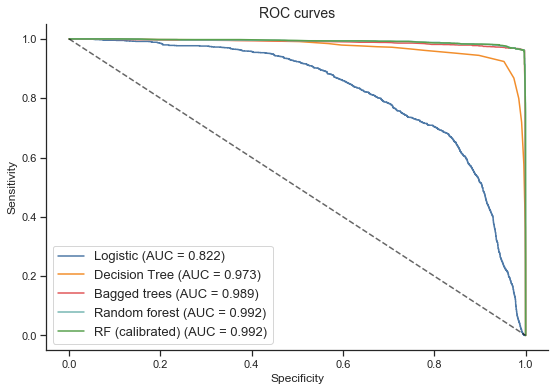

In [26]:
from statlearning import plot_roc_curves
fig, ax = plot_roc_curves(y_test, y_prob, labels=pd.Series(rows))
plt.show()

### Formatting

These two cells below format the notebook for display online. Please omit them from your work.

In [27]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [28]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')